In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/home/dekunma/anaconda3/envs/ds301/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [3]:
imgs = list(sorted(os.listdir("data/facemask_detection/images/")))

In [4]:
labels = list(sorted(os.listdir("data/facemask_detection/annotations/")))

In [5]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("data/facemask_detection/images/")))
#         self.labels = list(sorted(os.listdir("/kaggle/input/face-mask-detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("data/facemask_detection/images/", file_image)
        label_path = os.path.join("data/facemask_detection/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

In [8]:
torch.cuda.is_available()

True

# Model

In [8]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [9]:
model = get_model_instance_segmentation(3)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([0, 1, 0], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 2], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

# Train Model

In [11]:
from tqdm import tqdm

num_epochs = 50
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    tqdm_bar = tqdm(data_loader, desc="Epoch {}/{}".format(epoch+1, num_epochs))
    for imgs, annotations in tqdm_bar:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        tqdm_bar.set_description(f'Iteration: {i}/{len_dataloader}, Loss: {losses: .2f}')
        epoch_loss += losses
        
    print(f'Epoch {epoch} loss: {epoch_loss.item()}')

Iteration: 214/214, Loss:  0.19: 100%|██████████| 214/214 [01:03<00:00,  3.38it/s]


Epoch 0 loss: 87.95881652832031


Iteration: 214/214, Loss:  0.20: 100%|██████████| 214/214 [01:05<00:00,  3.29it/s]


Epoch 1 loss: 59.00229263305664


Iteration: 214/214, Loss:  0.12: 100%|██████████| 214/214 [01:00<00:00,  3.53it/s]


Epoch 2 loss: 49.13612747192383


Iteration: 214/214, Loss:  0.07: 100%|██████████| 214/214 [01:00<00:00,  3.52it/s]


Epoch 3 loss: 42.72978210449219


Iteration: 214/214, Loss:  0.07: 100%|██████████| 214/214 [01:00<00:00,  3.52it/s]


Epoch 4 loss: 40.34186935424805


Iteration: 214/214, Loss:  0.08: 100%|██████████| 214/214 [01:00<00:00,  3.51it/s]


Epoch 5 loss: 37.6833610534668


Iteration: 214/214, Loss:  0.06: 100%|██████████| 214/214 [01:01<00:00,  3.51it/s]


Epoch 6 loss: 33.8171501159668


Iteration: 214/214, Loss:  0.09: 100%|██████████| 214/214 [01:00<00:00,  3.51it/s]


Epoch 7 loss: 32.41218566894531


Iteration: 214/214, Loss:  0.05: 100%|██████████| 214/214 [01:00<00:00,  3.53it/s]


Epoch 8 loss: 31.560619354248047


Iteration: 214/214, Loss:  0.05: 100%|██████████| 214/214 [01:00<00:00,  3.54it/s]


Epoch 9 loss: 31.220661163330078


Iteration: 214/214, Loss:  0.06: 100%|██████████| 214/214 [01:00<00:00,  3.54it/s]


Epoch 10 loss: 29.629444122314453


Iteration: 214/214, Loss:  0.03: 100%|██████████| 214/214 [01:00<00:00,  3.52it/s]


Epoch 11 loss: 26.2734317779541


Iteration: 214/214, Loss:  0.07: 100%|██████████| 214/214 [01:00<00:00,  3.53it/s]


Epoch 12 loss: 24.18943214416504


Iteration: 214/214, Loss:  0.05: 100%|██████████| 214/214 [01:00<00:00,  3.54it/s]


Epoch 13 loss: 27.748369216918945


Iteration: 214/214, Loss:  0.03: 100%|██████████| 214/214 [01:00<00:00,  3.53it/s]


Epoch 14 loss: 24.268505096435547


Iteration: 214/214, Loss:  0.04: 100%|██████████| 214/214 [01:00<00:00,  3.53it/s]


Epoch 15 loss: 24.439146041870117


Iteration: 214/214, Loss:  0.04: 100%|██████████| 214/214 [01:00<00:00,  3.52it/s]


Epoch 16 loss: 24.201034545898438


Iteration: 214/214, Loss:  0.04: 100%|██████████| 214/214 [01:00<00:00,  3.55it/s]


Epoch 17 loss: 22.08981704711914


Iteration: 214/214, Loss:  0.03: 100%|██████████| 214/214 [01:00<00:00,  3.54it/s]


Epoch 18 loss: 21.495630264282227


Iteration: 214/214, Loss:  0.05: 100%|██████████| 214/214 [01:00<00:00,  3.54it/s]


Epoch 19 loss: 22.706491470336914


Iteration: 214/214, Loss:  0.05: 100%|██████████| 214/214 [01:00<00:00,  3.54it/s]


Epoch 20 loss: 23.074621200561523


Iteration: 214/214, Loss:  0.03: 100%|██████████| 214/214 [01:00<00:00,  3.53it/s]


Epoch 21 loss: 20.04477882385254


Iteration: 214/214, Loss:  0.05: 100%|██████████| 214/214 [01:00<00:00,  3.52it/s]


Epoch 22 loss: 23.16779327392578


Iteration: 214/214, Loss:  0.04: 100%|██████████| 214/214 [01:00<00:00,  3.53it/s]


Epoch 23 loss: 21.94523048400879


Iteration: 214/214, Loss:  0.02: 100%|██████████| 214/214 [01:00<00:00,  3.54it/s]


Epoch 24 loss: 20.814437866210938


Iteration: 214/214, Loss:  0.03: 100%|██████████| 214/214 [01:00<00:00,  3.55it/s]


Epoch 25 loss: 17.20508575439453


Iteration: 214/214, Loss:  0.02: 100%|██████████| 214/214 [01:00<00:00,  3.54it/s]


Epoch 26 loss: 19.198623657226562


Iteration: 214/214, Loss:  0.05: 100%|██████████| 214/214 [01:00<00:00,  3.54it/s]


Epoch 27 loss: 19.044179916381836


Iteration: 214/214, Loss:  0.03: 100%|██████████| 214/214 [01:00<00:00,  3.53it/s]


Epoch 28 loss: 19.68514060974121


Iteration: 214/214, Loss:  0.04: 100%|██████████| 214/214 [01:00<00:00,  3.52it/s]


Epoch 29 loss: 17.98506736755371


Iteration: 214/214, Loss:  0.04: 100%|██████████| 214/214 [01:00<00:00,  3.52it/s]


Epoch 30 loss: 18.53031349182129


Iteration: 214/214, Loss:  0.04: 100%|██████████| 214/214 [01:00<00:00,  3.53it/s]


Epoch 31 loss: 16.663808822631836


Iteration: 214/214, Loss:  0.02: 100%|██████████| 214/214 [01:00<00:00,  3.52it/s]


Epoch 32 loss: 14.614629745483398


Iteration: 214/214, Loss:  0.04: 100%|██████████| 214/214 [01:00<00:00,  3.53it/s]


Epoch 33 loss: 17.291854858398438


Iteration: 214/214, Loss:  0.04: 100%|██████████| 214/214 [01:00<00:00,  3.53it/s]


Epoch 34 loss: 18.6434326171875


Iteration: 214/214, Loss:  0.03: 100%|██████████| 214/214 [01:00<00:00,  3.51it/s]


Epoch 35 loss: 16.656553268432617


Iteration: 214/214, Loss:  0.03: 100%|██████████| 214/214 [01:00<00:00,  3.55it/s]


Epoch 36 loss: 14.128941535949707


Iteration: 214/214, Loss:  0.02: 100%|██████████| 214/214 [01:00<00:00,  3.52it/s]


Epoch 37 loss: 16.70527458190918


Iteration: 214/214, Loss:  0.02: 100%|██████████| 214/214 [01:00<00:00,  3.52it/s]


Epoch 38 loss: 18.253971099853516


Iteration: 214/214, Loss:  0.04: 100%|██████████| 214/214 [01:00<00:00,  3.54it/s]


Epoch 39 loss: 15.787884712219238


Iteration: 214/214, Loss:  0.02: 100%|██████████| 214/214 [01:00<00:00,  3.54it/s]


Epoch 40 loss: 16.261516571044922


Iteration: 214/214, Loss:  0.03: 100%|██████████| 214/214 [01:00<00:00,  3.53it/s]


Epoch 41 loss: 16.20337677001953


Iteration: 214/214, Loss:  0.02: 100%|██████████| 214/214 [01:00<00:00,  3.52it/s]


Epoch 42 loss: 16.36760711669922


Iteration: 214/214, Loss:  0.02: 100%|██████████| 214/214 [01:00<00:00,  3.51it/s]


Epoch 43 loss: 17.976675033569336


Iteration: 214/214, Loss:  0.02: 100%|██████████| 214/214 [01:00<00:00,  3.53it/s]


Epoch 44 loss: 15.153640747070312


Iteration: 214/214, Loss:  0.03: 100%|██████████| 214/214 [01:00<00:00,  3.51it/s]


Epoch 45 loss: 16.612611770629883


Iteration: 214/214, Loss:  0.02: 100%|██████████| 214/214 [01:00<00:00,  3.53it/s]


Epoch 46 loss: 15.862195014953613


Iteration: 214/214, Loss:  0.03: 100%|██████████| 214/214 [01:00<00:00,  3.53it/s]


Epoch 47 loss: 16.8105525970459


Iteration: 214/214, Loss:  0.02: 100%|██████████| 214/214 [01:00<00:00,  3.56it/s]


Epoch 48 loss: 15.51625919342041


Iteration: 214/214, Loss:  0.03: 100%|██████████| 214/214 [01:00<00:00,  3.53it/s]

Epoch 49 loss: 16.112897872924805


In [12]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [13]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([[184.7624, 101.5231, 224.6495, 143.4017]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9979], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[318.5369,  32.4556, 352.5680,  69.4651],
          [224.2176,  35.5434, 258.9287,  73.8002],
          [143.0376,  74.3303, 172.2742, 112.2797],
          [ 20.7485,  70.9450,  42.7877,  91.6707],
          [193.2983,  65.2010, 215.9897,  90.1220],
          [298.1723,  58.5060, 312.6882,  80.0922],
          [366.5279,  70.2064, 394.1618,  97.0485],
          [143.4069,  74.0317, 172.1299, 109.0848],
          [367.0080,  69.7360, 394.3254,  96.4159]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 2, 2], device='cuda:0'),
  'scores': tensor([0.9976, 0.9976, 0.9969, 0.9873, 0.9643, 0.8587, 0.3535, 0.0849, 0.0515],
         device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[ 71.3

# Function to plot image

In [14]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.detach().cpu()

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        box = box.detach().cpu().numpy()
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Prediction


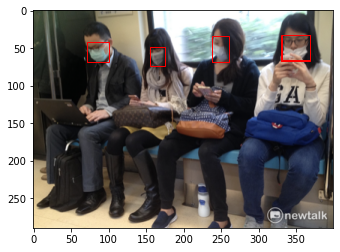

Target


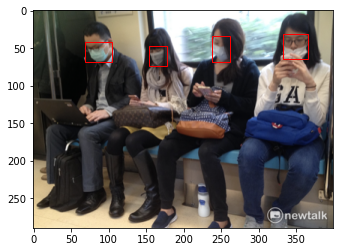

In [15]:
print("Prediction")
plot_image(imgs[2], preds[2])
print("Target")
plot_image(imgs[2], annotations[2])

In [16]:
torch.save(model.state_dict(),'faster_rcnn.pth')

In [18]:
print(imgs[0].shape)

torch.Size([3, 366, 512])


In [2]:
model2 = get_model_instance_segmentation(3)

NameError: name 'get_model_instance_segmentation' is not defined

# Save Model

In [6]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model2 = get_model_instance_segmentation(3)
model2.load_state_dict(torch.load('faster_rcnn.pth'))
model2.eval()
model2.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Load Model

In [9]:
pred2 = model2(imgs)

AttributeError: 'str' object has no attribute 'shape'

In [ ]:
print("Predict with loaded model")
plot_image(imgs[3], pred2[3])